In [1]:
import os, sys
sys.path.append(os.path.split(sys.path[0])[0])

import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py
import scipy.io
import pandas as pd

import config.params as params
import config.paths as paths
from stylized_module.base.simulate_cells import SimulationRunner
from stylized_module.models.SummaryStats2D import cat_output
from utils.transform.distribution_transformation import norm2unif, range2logn, norm2logn, logds_norm2unif, logds_norm2logn
from utils.plotting.plot_results import plot_LFP_traces,plot_LFP_heatmap
from utils.spike_window import first_pk_tr, get_spike_window
import config.paths as paths
from utils.metrics.corrcoef import corrcoef, max_corrcoef
import sbi.analysis as analysis

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

(array([  1.,   7.,  19.,  90., 300., 425., 118.,  31.,   6.,   3.]),
 array([-40.7996938 , -38.59235027, -36.38500675, -34.17766323,
        -31.9703197 , -29.76297618, -27.55563266, -25.34828913,
        -23.14094561, -20.93360209, -18.72625856]),
 <BarContainer object of 10 artists>)

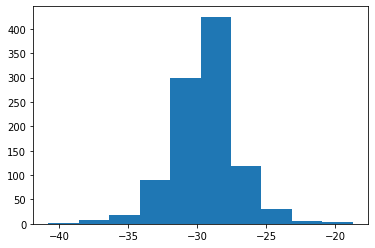

In [2]:
with open("../posterior_maf1.pkl", "rb") as handle:
    posterior = pickle.load(handle)

simR = SimulationRunner()
x_o = cat_output(simR.x0_trace)
samples = posterior.sample((1000,), x=x_o)#, sample_with='mcmc') #, sample_with_mcmc=True

#posterior.leakage_correction(x_o, num_rejection_samples=1000)
log_probability = posterior.log_prob(samples,x=x_o, norm_posterior=False) #, norm_posterior=False
log_prob_t = log_probability
for i in range(6):
    log_prob_t += logds_norm2unif(samples[:,i], params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
for i in range(6,11):
    if i == 6:
        m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1], n_sigma=3)
    else:
        m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
    log_prob_t += logds_norm2logn(samples[:,i], m, s)
plt.hist(log_prob_t.numpy())

In [3]:
sample_idx = np.argmax(log_prob_t)
samples_t = torch.clone(samples)
for i in range(6):
    samples_t[:,i] = torch.from_numpy(norm2unif(samples[:,i], params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1]))
for i in range(6,11):
    if i == 6:
        m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1], n_sigma=3)
    else:
        m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
    samples_t[:,i] = norm2logn(samples[:,i], m, s)
predicted_post = samples[sample_idx]
predicted_post = torch.unsqueeze(predicted_post, 0)
print(predicted_post)
print(params.GT_LOCATION_PARAMETERS)
df = pd.read_csv(paths.GEO_STANDARD)
print(df)

tensor([[ 0.1356,  5.3352, -0.4626,  0.2212,  1.9016,  0.7420, -0.8614, -0.6953,
          0.6290,  1.6981, -1.1365]])
[0.685, 350, 49.995, 1.43, 0.0, 0.8]
   id    name  type  axial      L    R       ang  pid
0   0    soma     1   True    0.0  6.0  0.000000    0
1   1   basal     3  False  200.0  0.5 -0.707107    0
2   2  apical     4  False  200.0  0.5  0.000000    0
3   3   trunk     4   True  400.0  0.5  1.570796    0
4   4    tuft     4  False  200.0  0.5  0.707107    3


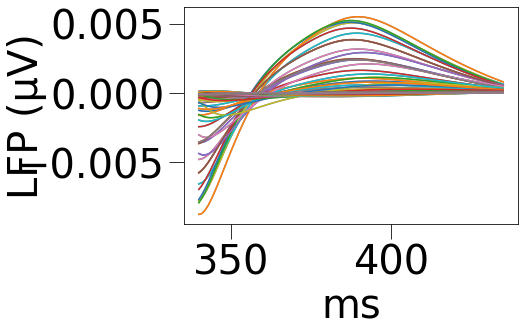

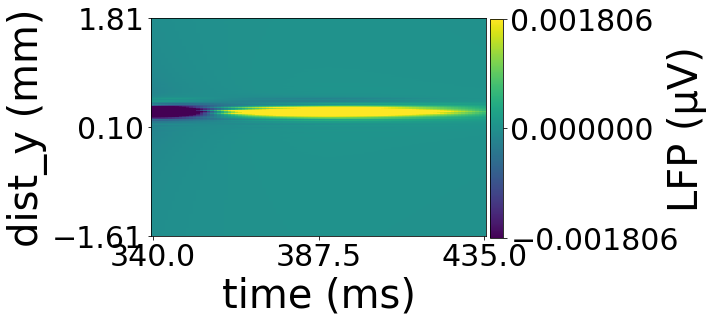

In [4]:
save_xo = params.IM_SAVE_X0
# save_xo = 'x_0_traces.pdf'
fig,ax = plot_LFP_traces(simR.t0,simR.x0_trace,savefig=params.IM_SAVE_X0)
# save_xo = 'x_0_HTmap.pdf'
elec_idx = slice(30,-10)
fig,ax = plot_LFP_heatmap(simR.t0,params.IM_Y_DISTANCE[elec_idx],simR.x0_trace[:,elec_idx],vlim='auto',savefig=params.IM_SAVE_X0)

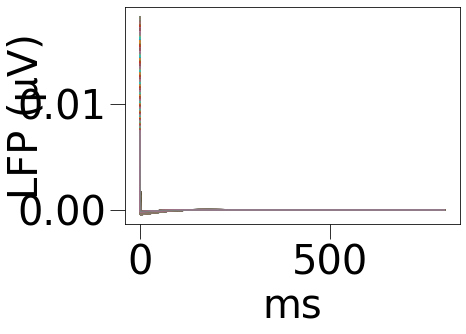

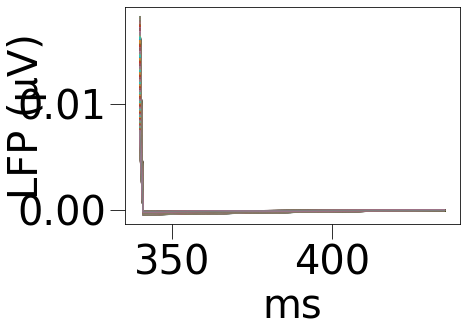

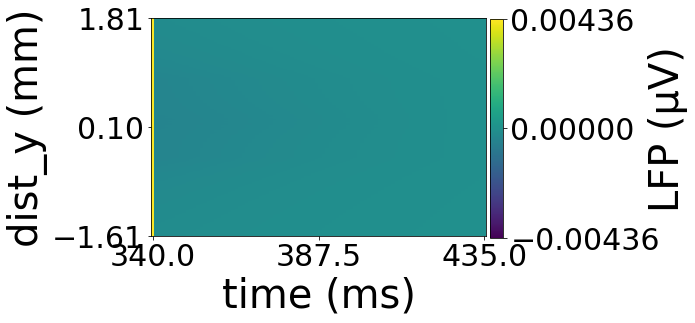

In [5]:
fst_idx=10
# predicted_lfp = passive_model(params.IM_RANDOM_SAMPLE,whole_trace=True)
predicted_lfp = simR.run_sim_from_sample(predicted_post,fst_idx=0,whole_trace=True,ncells=1)

predicted_lfp = np.squeeze(predicted_lfp)
fig,ax = plot_LFP_traces(np.arange(predicted_lfp.shape[0]),predicted_lfp)
start,end = get_spike_window(predicted_lfp,win_size=params.AM_WINDOW_SIZE,align_at=fst_idx)
predicted_lfp_win = predicted_lfp[start:end,:]

savefig = paths.PASSIVE_INFERENCE_SAVE_TRACES if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_TRACES
fig,ax = plot_LFP_traces(simR.t0,
                         predicted_lfp_win,
                         savefig=savefig)

savefig = paths.PASSIVE_INFERENCE_SAVE_HEATMAPS if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_HEATMAPS
fig,ax = plot_LFP_heatmap(simR.t0,
                          params.IM_Y_DISTANCE[elec_idx],
                          predicted_lfp_win[:,elec_idx],
                          vlim='auto',
                          savefig=savefig)

In [6]:
max_corr, max_ind = max_corrcoef(simR.x0_trace,predicted_lfp)
print(max_corr,max_ind)
max_corr, max_ind = max_corrcoef(simR.x0_trace,predicted_lfp_win)
print(max_corr,max_ind)

0.38162127381296357 107
-0.074984756316121 0


In [7]:
hf_file = paths.PASSIVE_INFERENCE_RESULTS_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_DATA
hf = h5py.File(hf_file, 'w')
hf.create_dataset('LFP',data=predicted_lfp)
hf.create_dataset('samples',data=samples.numpy())
hf.create_dataset('log_prob',data=log_probability.numpy())
hf.close()

mat_file = paths.PASSIVE_INFERENCE_RESULTS_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':predicted_lfp_win[:,elec_idx],'t':simR.t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

mat_file = paths.PASSIVE_INFERENCE_RESULTS_X0_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_X0_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':simR.x0_trace[:,elec_idx],'t':simR.t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

torch.Size([1000, 11])
torch.Size([1, 11])


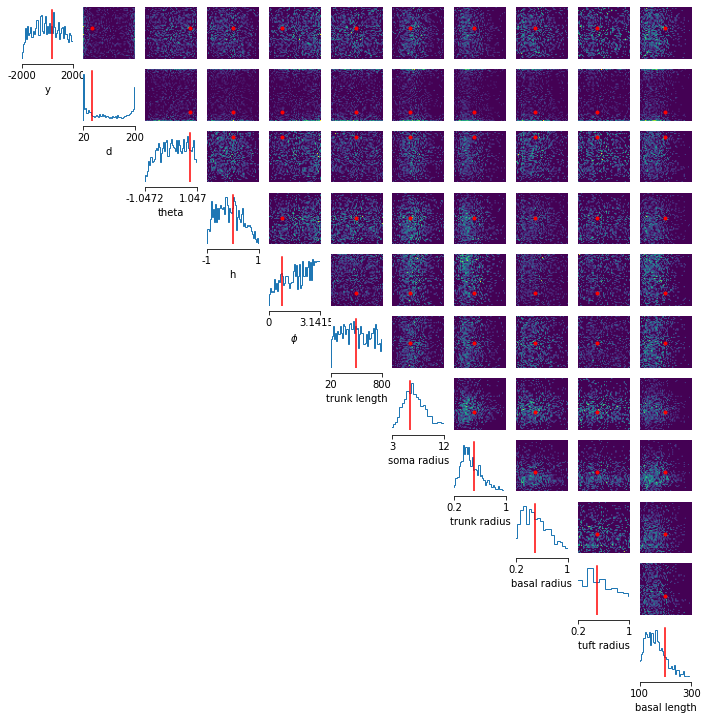

In [8]:
labels_params = params.IM_GRAPHING_LABELS #= [r'y',r'd',r'$\theta$',r'h',r'$\phi$',r'soma radius',r'trunk length',r'trunk radius',r'basal radius',r'tuft radius',r'basal length']
print(samples_t.shape)
points = torch.Tensor([[350],[50],[np.pi/4], [0.0], [0.8], [400.0], [6.0], [0.5], [0.5], [0.5], [200.0]]).reshape(-1,11)
print(points.shape)
fig, axes = analysis.pairplot(samples_t,
                           limits = params.IM_PARAMETER_BOUNDS,
                           ticks = params.IM_PARAMETER_BOUNDS,
                           figsize=(12,12),
                           points=points,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');